## Step 1 - Preliminaries

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data():
    # Read data
    data_dir = Path("./input")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

## Data Preprocessing

### Clean Data

In [3]:
data_dir = Path("./input")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

print(df.Exterior2nd.unique())

['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']


#### TODO: replace `GarageYrBlt` only when < `YeraBuilt`

In [4]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "ThreeSeasonPorch",
    }, inplace=True)
    return df

In [5]:
df[['YearBuilt', 'GarageYrBlt']].loc[df.GarageYrBlt != df.YearBuilt]

,YearBuilt,GarageYrBlt
Id,,
4,1915,1998.0
16,1929,1991.0
27,1951,2005.0
28,2007,2008.0
30,1927,1920.0
...,...,...
1446,1966,1990.0
1449,1910,1950.0
1450,1970,NaN


### Encode the Statistical Data Type

In [6]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df

### Handle Missing Values

Handling missing values now will make the feature engineering go more smoothly. We'll impute 0 for missing numeric values and "None" for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: 1 whenever a value was imputed and 0 otherwise.

##### TODO: `fillna(-1)` for `number` columns

In [7]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load Data

In [8]:
df_train, df_test = load_data()

In [9]:
# Peek at the values
# display(df_train)
#display(df_test)

# Display information about dtypes and missing values
display(df_train.info())
#display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

None

#### TO IMPROVE:
1. Convert to float64:
    * LotArea
    * 1stFlrSF
    * 2ndFlrSF
    * LowQualFinSF
    * GrLivArea
    * WoodDeckSF
    * OpenPorchSF
    * ThreeSeasonPorch
    * EnclosedPorch
    * ScreenPorch
    * PoolArea
    * MiscVal
2. Convert to int:
    * GarageCars
    * GarageYrBlt


### Establish Baseline

In [10]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [11]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


> Baseline score: 0.14351 RMSLE

## Step 2 - Feature Utility Scores

In [12]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [13]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

In [14]:
print(mi_scores)

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64


The top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [15]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [16]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.14338026718687277

## Step 3 - Create Features

### Label encoding for the categorical features

A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories. If you wanted to try a linear regression model (also popular in this competition), you would instead want to use a one-hot encoding, especially for the features with unordered categories.

In [17]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

### Create Features with Pandas

In [18]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "ThreeSeasonPorch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

### TO IMPROVE

Here are some ideas for other transforms you could explore:
* Interactions between the quality `Qual` and condition `Cond` features. `OverallQual`, for instance, was a high-scoring feature. You could try combining it with `OverallCond` by converting both to integer type and taking a product. (`OverallQual * OverallCond / 100`)
* Square roots of area features. This would convert units of square feet to just feet.
* Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
* Interactions between numeric and categorical features that describe the same thing. You could look at interactions between BsmtQual and TotalBsmtSF, for instance.
* Other group statistics in Neighboorhood. We did the median of GrLivArea. Looking at mean, std, or count could be interesting. You could also try combining the group statistics with other features. Maybe the difference of GrLivArea and the median is important?

### k-Means Clustering

In [19]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

### Principal Component Analysis

In [20]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

In [21]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

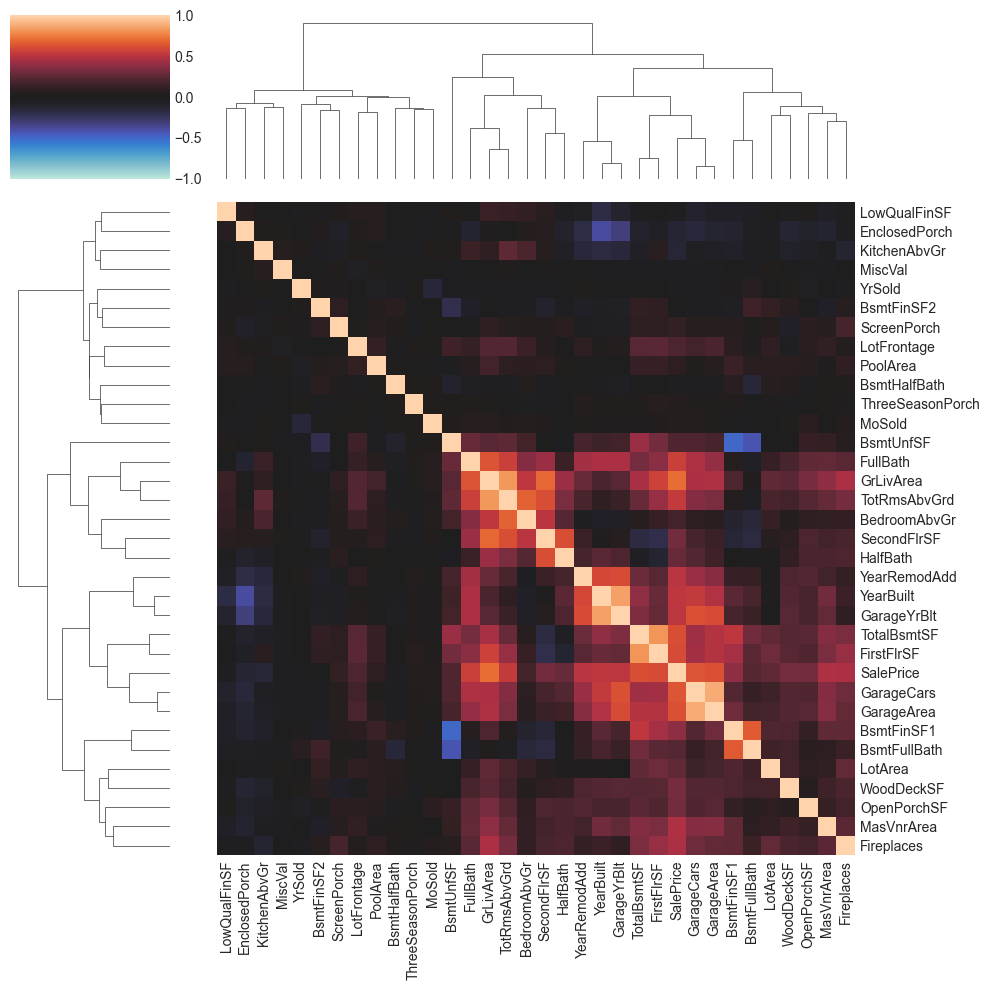

In [22]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

#### PCA Application - Indicate Outliers

In [23]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

### Target Encoding

In [24]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [25]:
# Usage:
# encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
# X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"])

### Create Final Feature Set

In [26]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.1381925629969659

## Step 4 - Hyperparameter Tuning

In [32]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=3,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12330958533840694

Just tuning these by hand can give you great results. However, you might like to try using one of scikit-learn's automatic [hyperparameter tuners](https://scikit-learn.org/stable/modules/grid_search.html). Or you could explore more advanced tuning libraries like [Optuna](https://optuna.readthedocs.io/en/stable/index.html) or [scikit-optimize](https://optuna.readthedocs.io/en/stable/index.html).

In [33]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params
xgb_params

[I 2023-06-22 15:52:43,549] A new study created in memory with name: no-name-b3ddcea1-79a9-4b59-b578-f82282e86345
[I 2023-06-22 15:53:16,991] Trial 0 finished with value: 0.12434549785546951 and parameters: {'max_depth': 3, 'learning_rate': 0.061072736717501186, 'n_estimators': 6770, 'min_child_weight': 8, 'colsample_bytree': 0.9286643915046107, 'subsample': 0.6320465834736828, 'reg_alpha': 0.9760779278013259, 'reg_lambda': 7.206927601644354}. Best is trial 0 with value: 0.12434549785546951.
[I 2023-06-22 15:53:24,488] Trial 1 finished with value: 1.3049864585494142 and parameters: {'max_depth': 5, 'learning_rate': 0.0015570952791056439, 'n_estimators': 1408, 'min_child_weight': 10, 'colsample_bytree': 0.7018198065271055, 'subsample': 0.5014978951384079, 'reg_alpha': 0.0003242944514497969, 'reg_lambda': 0.4148100460370229}. Best is trial 0 with value: 0.12434549785546951.
[I 2023-06-22 15:53:41,796] Trial 2 finished with value: 0.12116884479564669 and parameters: {'max_depth': 9, 'lear

{'max_depth': 4,
 'learning_rate': 0.007145326785474656,
 'n_estimators': 2248,
 'min_child_weight': 3,
 'colsample_bytree': 0.8511472281684561,
 'subsample': 0.4012884711711879,
 'reg_alpha': 0.0010316562969172737,
 'reg_lambda': 0.00010663475022956113}

In [34]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=4,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.007,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=2200,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=3,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.85,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.4,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.001,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.0001,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=3,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.1166805546044155

After it's done, you might enjoy using some of [Optuna's visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html).

## Step 5 - Train Model and Create Submissions

In [35]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

Your submission was successfully saved!


In [39]:
predictions

array([127000.76, 165255.7 , 189182.94, ..., 151207.44, 117245.43,
       200469.2 ], dtype=float32)

In [41]:
rounded_predictions = predictions.round(-1).astype(int)

In [42]:
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': rounded_predictions})
output.to_csv('output/baseline_w_hyperparameter_tuning.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
